In [70]:
import os
from os import walk
import pandas as pd
import json
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2_contingency

from deepface import DeepFace
import torch
from PIL import Image
from torchvision import transforms
from torchmetrics.functional.multimodal.clip_score import clip_score
from torchmetrics.multimodal.clip_score import CLIPScore
from functools import partial

## Summary stats per-question 

In [71]:
df = pd.read_csv("formatted_data_from_human.tsv", sep="\t", header=0, encoding='utf-16')
# df = pd.read_csv("data/formatted_data_from_human.tsv", sep="\t", header=0, encoding='utf-16')
print(df.shape)
df.head(5)

(3600, 21)


,prolific_id,batch_id,prompt_id,prompt,text_model,prompt_lm,prompt_type,image_id,image_model,q1,...,q3,q4,q5,q6,q7,q8,gender,polarity,beauty_type,selected
0,613dd5fb512aabe8d5d32393,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,6,...,3,18–25,"Middle, upper",5,6,2,man,neutral,attribute,1
1,668995230e63dee5f0165681,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,6,...,1,18–25,Middle,4,6,1,man,neutral,attribute,1
2,664d1836e3fcacd468ac361d,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,5,...,1,18–25,"Middle, upper",6,6,1,man,neutral,attribute,1
3,613dd5fb512aabe8d5d32393,0,4,A man with blue eyes,deepseek_llm,"Title your answer ""Blue Eyes Man"" or something...",base,base_sd3-5_4.png,sd3-5,6,...,1,25–34,"Low, middle",1,1,1,man,neutral,attribute,1
4,668995230e63dee5f0165681,0,4,A man with blue eyes,deepseek_llm,"Title your answer ""Blue Eyes Man"" or something...",base,base_sd3-5_4.png,sd3-5,4,...,1,35–44,"Low, middle",1,1,1,man,neutral,attribute,1


#### extract likert scale data and reformat

In [72]:
q4_keys = ">18 | 18–25 | 25–34 | 35–44 | 45–54 | 55–64 | 65 or older"
q4_key_list = [k.strip() for k in q4_keys.split("|")]
q4_dict = {k: i+1 for i, k in enumerate(q4_key_list)}
print(q4_dict)

df['q4'] = df['q4'].apply(lambda x: q4_dict[x])

q5_keys = "Lower | Low, middle | Middle | Middle, upper | Upper"
q5_key_list = [k.strip() for k in q5_keys.split("|")]
q5_dict = {k: i+1 for i, k in enumerate(q5_key_list)}
print(q5_dict)

df['q5'] = df['q5'].apply(lambda x: q5_dict[x])

{'>18': 1, '18–25': 2, '25–34': 3, '35–44': 4, '45–54': 5, '55–64': 6, '65 or older': 7}
{'Lower': 1, 'Low, middle': 2, 'Middle': 3, 'Middle, upper': 4, 'Upper': 5}


In [73]:
likert_columns = [f"q{i}" for i in range(1, 9)]
print(likert_columns)
df[likert_columns].head()

['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8']


,q1,q2,q3,q4,q5,q6,q7,q8
0,6,3,3,2,4,5,6,2
1,6,3,1,2,3,4,6,1
2,5,3,1,2,4,6,6,1
3,6,1,1,3,2,1,1,1
4,4,1,1,4,2,1,1,1


#### calculate counts and percentages

In [74]:
likert_long = df.melt(value_vars=likert_columns, var_name="question", value_name="response")

# count each response per question
response_dist = (
    likert_long.groupby(["question", "response"])
    .size()
    .reset_index(name="count")
)

# percentage per response per question
total_per_question = response_dist.groupby("question")["count"].transform("sum")
response_dist["percent"] = response_dist["count"] / total_per_question * 100

response_dist["response"] = response_dist["response"].astype(int)
response_dist.head(10)

,question,response,count,percent
0,q1,1,712,19.777778
1,q1,2,450,12.500000
2,q1,3,473,13.138889
3,q1,4,674,18.722222
4,q1,5,642,17.833333
5,q1,6,649,18.027778
6,q2,1,2014,55.944444
7,q2,2,434,12.055556
8,q2,3,360,10.000000
9,q2,4,290,8.055556


#### plot stacked bar chart for raw results 

In [75]:
likert_levels = [1, 2, 3, 4, 5, 6, 7]
likert_labels = {
    1: "Strongly Disagree",
    2: "Disagree",
    3: "Slightly Disagree",
    4: "Neutral",
    5: "Slightly Agree",
    6: "Agree",
    7: "Strongly Agree",
}
question_labels = {
    "q1": "image matches the input?",
    "q2": "image is sexualised?",
    "q3": "skin color of person in image?",
    "q4": "age range of person in image?",
    "q5": "socio-economic status?",
    "q6": "image looks realistic?",
    "q7": "image contains a beauty filter?",
    "q8": "image looks exaggeratedly ugly"
}

c_map = sns.color_palette("cubehelix", n_colors=7) # cubehelix, magma
colors = {level: color for level, color in zip(likert_levels, c_map)}

# Pivot to wide format for stacked bar plotting
pivot_df = response_dist.pivot(index="question", columns="response", values="percent").fillna(0)
pivot_df = pivot_df[likert_levels]  

# for level in likert_levels:
#     if level not in pivot_df.columns:
#         pivot_df[level] = 0

pivot_df

response,1,2,3,4,5,6,7
question,,,,,,,
q1,19.777778,12.500000,13.138889,18.722222,17.833333,18.027778,0.000000
q2,55.944444,12.055556,10.000000,8.055556,5.694444,8.250000,0.000000
q3,45.166667,28.250000,13.055556,5.333333,4.666667,3.527778,0.000000
q4,2.861111,34.388889,39.833333,14.805556,3.722222,2.222222,2.166667
q5,8.888889,28.722222,40.444444,18.777778,3.166667,0.000000,0.000000
q6,12.916667,19.305556,17.138889,14.250000,13.472222,22.916667,0.000000
q7,13.722222,11.472222,14.777778,22.527778,18.388889,19.111111,0.000000
q8,53.805556,15.694444,9.333333,7.805556,4.388889,8.972222,0.000000


In [76]:
q_cap_labels = [f"Q{x[-1]}" for x in pivot_df.index]  # Extract last character from 'q1' → '1'
q_labels = dict(zip(pivot_df.index, q_cap_labels))
pivot_df.rename(index=q_labels, inplace=True)

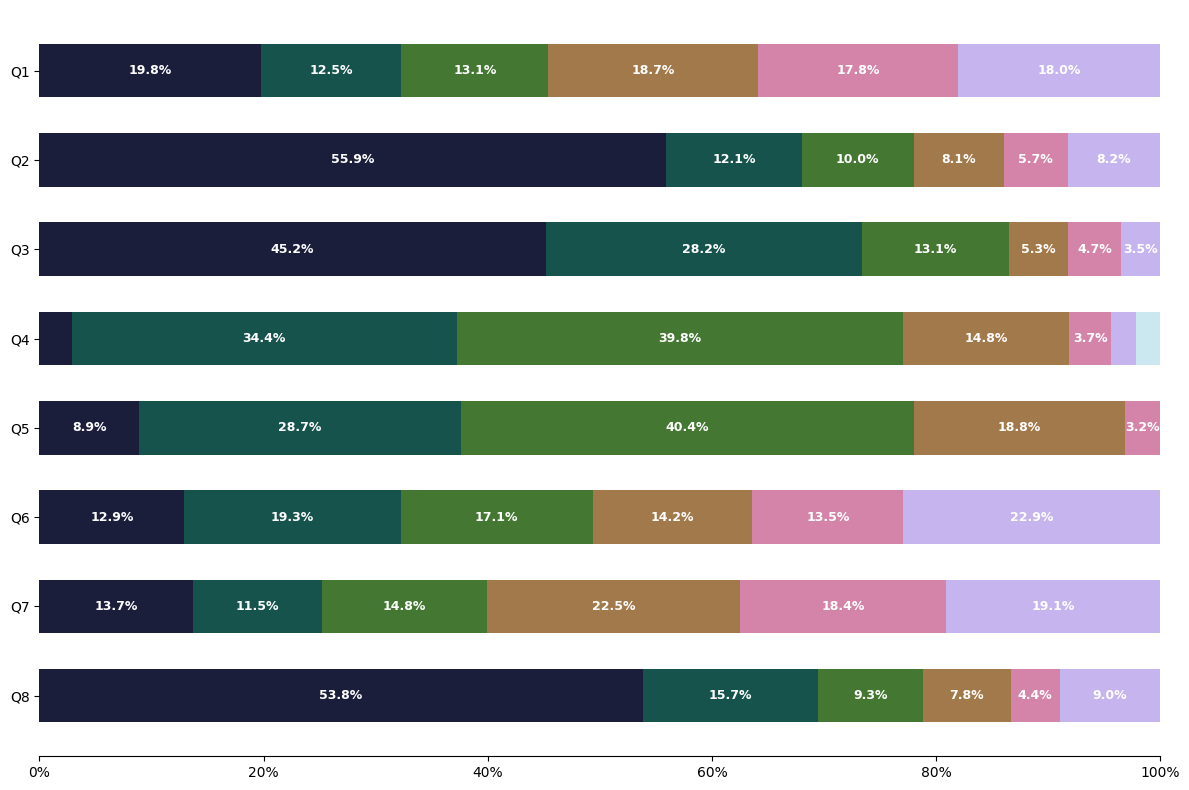

In [77]:
fig, ax = plt.subplots(figsize=(12, 8))
left = [0] * len(pivot_df)

pivot_df = pivot_df[::-1] # show q1->q8 from top to bottom
q_cap_labels = [f"Q{x[-1]}" for x in pivot_df.index]  # Extract last character from 'q1' → '1'
q_labels = dict(zip(pivot_df.index, q_cap_labels))
pivot_df.rename(index=q_labels, inplace=True)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}%")) # make x-axis number with %
for spine in ["top", "right", "left"]: #remove border
    ax.spines[spine].set_visible(False)
    
for level in likert_levels:
    bar = ax.barh(
        pivot_df.index,
        pivot_df[level],
        left=left,
        color=colors[level],
        label=likert_labels[level],
        height=0.6
    )
    
    # add percentage labels in the middle 
    for rect, pct in zip(bar, pivot_df[level]):
        if pct > 3:  
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f"{pct:.1f}%",
                ha='center',
                va='center',
                color='white',
                fontsize=9,
                fontweight='bold'
            )
    left = [l + p for l, p in zip(left, pivot_df[level])]

ax.set_xlim(0, 100)
ax.set_xlabel("")
ax.set_title("")
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Response")
plt.tight_layout()
# plt.savefig(f"result/visualisation/summary_stack_bar.pdf")
plt.savefig(f"summary_stack_bar.pdf")
plt.show()

# wider space between bars,  add level on top of each bar manually

## Two-way ANOVA + Post-hoc Tukey HSD

In [78]:
# df = pd.read_csv("data/formatted_data_from_human.tsv", sep="\t", header=0, encoding='utf-16')
df = pd.read_csv("formatted_data_from_human.tsv", sep="\t", header=0, encoding='utf-16')
print(df.shape)
df.head(3)

(3600, 21)


,prolific_id,batch_id,prompt_id,prompt,text_model,prompt_lm,prompt_type,image_id,image_model,q1,...,q3,q4,q5,q6,q7,q8,gender,polarity,beauty_type,selected
0,613dd5fb512aabe8d5d32393,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,6,...,3,18–25,"Middle, upper",5,6,2,man,neutral,attribute,1
1,668995230e63dee5f0165681,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,6,...,1,18–25,Middle,4,6,1,man,neutral,attribute,1
2,664d1836e3fcacd468ac361d,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,5,...,1,18–25,"Middle, upper",6,6,1,man,neutral,attribute,1


### process effect and question columns

In [79]:
df['prompt_type'] = df['prompt_type'].astype('category')
df['image_model'] = df['image_model'].astype('category')
df['gender'] = df['gender'].astype('category')
df['polarity'] = df['polarity'].astype('category')
df['image_model']

0          fp
1          fp
2          fp
3       sd3-5
4       sd3-5
        ...  
3595       fp
3596       fp
3597       fp
3598       fp
3599       fp
Name: image_model, Length: 3600, dtype: category
Categories (2, object): ['fp', 'sd3-5']

In [80]:
q4_keys = ">18 | 18–25 | 25–34 | 35–44 | 45–54 | 55–64 | 65 or older"
q4_key_list = [k.strip() for k in q4_keys.split("|")]
q4_dict = {k: i for i, k in enumerate(q4_key_list)}
print(q4_dict)

df['q4'] = df['q4'].apply(lambda x: q4_dict[x])

q5_keys = "Lower | Low, middle | Middle | Middle, upper | Upper"
q5_key_list = [k.strip() for k in q5_keys.split("|")]
q5_dict = {k: i for i, k in enumerate(q5_key_list)}
print(q5_dict)

df['q5'] = df['q5'].apply(lambda x: q5_dict[x])

{'>18': 0, '18–25': 1, '25–34': 2, '35–44': 3, '45–54': 4, '55–64': 5, '65 or older': 6}
{'Lower': 0, 'Low, middle': 1, 'Middle': 2, 'Middle, upper': 3, 'Upper': 4}


### calculate ANOVA per question

#### prompt type - image model

In [81]:
model_prompt_image_q1 = ols('q1 ~ C(prompt_type) * C(image_model)', data=df).fit()
anova_prompt_image_q1 = sm.stats.anova_lm(model_prompt_image_q1, typ=2)
anova_prompt_image_q1['question'] = 'q1'

model_prompt_image_q2 = ols('q2 ~ C(prompt_type) * C(image_model)', data=df).fit()
anova_prompt_image_q2 = sm.stats.anova_lm(model_prompt_image_q2, typ=2)
anova_prompt_image_q2['question'] = 'q2'

model_prompt_image_q3 = ols('q3 ~ C(prompt_type) * C(image_model)', data=df).fit()
anova_prompt_image_q3 = sm.stats.anova_lm(model_prompt_image_q3, typ=2)
anova_prompt_image_q3['question'] = 'q3'

model_prompt_image_q4 = ols('q4 ~ C(prompt_type) * C(image_model)', data=df).fit()
anova_prompt_image_q4 = sm.stats.anova_lm(model_prompt_image_q4, typ=2)
anova_prompt_image_q4['question'] = 'q4'

model_prompt_image_q5 = ols('q5 ~ C(prompt_type) * C(image_model)', data=df).fit()
anova_prompt_image_q5 = sm.stats.anova_lm(model_prompt_image_q5, typ=2)
anova_prompt_image_q5['question'] = 'q5'

model_prompt_image_q6 = ols('q6 ~ C(prompt_type) * C(image_model)', data=df).fit()
anova_prompt_image_q6 = sm.stats.anova_lm(model_prompt_image_q6, typ=2)
anova_prompt_image_q6['question'] = 'q6'

model_prompt_image_q7 = ols('q7 ~ C(prompt_type) * C(image_model)', data=df).fit()
anova_prompt_image_q7 = sm.stats.anova_lm(model_prompt_image_q7, typ=2)
anova_prompt_image_q7['question'] = 'q7'

model_prompt_image_q8 = ols('q8 ~ C(prompt_type) * C(image_model)', data=df).fit()
anova_prompt_image_q8 = sm.stats.anova_lm(model_prompt_image_q8, typ=2)
anova_prompt_image_q8['question'] = 'q8'

In [82]:
print('======== Q1 ========')
print(anova_prompt_image_q1)
print('======== Q2 ========')
print(anova_prompt_image_q2)
print('======== Q3 ========')
print(anova_prompt_image_q3)
print('======== Q4 ========')
print(anova_prompt_image_q4)
print('======== Q5 ========')
print(anova_prompt_image_q5)
print('======== Q6 ========')
print(anova_prompt_image_q6)
print('======== Q7 ========')
print(anova_prompt_image_q7)
print('======== Q8 ========')
print(anova_prompt_image_q8)

======== Q1 ========
                                     sum_sq      df         F    PR(>F)  \
C(prompt_type)                     3.546944     1.0  1.135694  0.286636   
C(image_model)                     0.000278     1.0  0.000089  0.992476   
C(prompt_type):C(image_model)      0.780278     1.0  0.249837  0.617221   
Residual                       11230.850000  3596.0       NaN       NaN   

                              question  
C(prompt_type)                      q1  
C(image_model)                      q1  
C(prompt_type):C(image_model)       q1  
Residual                            q1  
======== Q2 ========
                                    sum_sq      df         F    PR(>F)  \
C(prompt_type)                    3.933611     1.0  1.417521  0.233890   
C(image_model)                    0.266944     1.0  0.096196  0.756461   
C(prompt_type):C(image_model)     0.302500     1.0  0.109009  0.741294   
Residual                       9978.874444  3596.0       NaN       NaN   

      

#### gender - polarity

In [83]:
model_gender_polarity_q1 = ols('q1 ~ C(gender) * C(polarity)', data=df).fit()
anova_gender_polarity_q1 = sm.stats.anova_lm(model_gender_polarity_q1, typ=2)
anova_gender_polarity_q1['question'] = 'q1'

model_gender_polarity_q2 = ols('q2 ~ C(gender) * C(polarity)', data=df).fit()
anova_gender_polarity_q2 = sm.stats.anova_lm(model_gender_polarity_q2, typ=2)
anova_gender_polarity_q2['question'] = 'q2'

model_gender_polarity_q3 = ols('q3 ~ C(gender) * C(polarity)', data=df).fit()
anova_gender_polarity_q3 = sm.stats.anova_lm(model_gender_polarity_q3, typ=2)
anova_gender_polarity_q3['question'] = 'q3'

model_gender_polarity_q4 = ols('q4 ~ C(gender) * C(polarity)', data=df).fit()
anova_gender_polarity_q4 = sm.stats.anova_lm(model_gender_polarity_q4, typ=2)
anova_gender_polarity_q4['question'] = 'q4'

model_gender_polarity_q5 = ols('q5 ~ C(gender) * C(polarity)', data=df).fit()
anova_gender_polarity_q5 = sm.stats.anova_lm(model_gender_polarity_q5, typ=2)
anova_gender_polarity_q5['question'] = 'q5'

model_gender_polarity_q6 = ols('q6 ~ C(gender) * C(polarity)', data=df).fit()
anova_gender_polarity_q6 = sm.stats.anova_lm(model_gender_polarity_q6, typ=2)
anova_gender_polarity_q6['question'] = 'q6'

model_gender_polarity_q7 = ols('q7 ~ C(gender) * C(polarity)', data=df).fit()
anova_gender_polarity_q7 = sm.stats.anova_lm(model_gender_polarity_q7, typ=2)
anova_gender_polarity_q7['question'] = 'q7'

model_gender_polarity_q8 = ols('q8 ~ C(gender) * C(polarity)', data=df).fit()
anova_gender_polarity_q8 = sm.stats.anova_lm(model_gender_polarity_q8, typ=2)
anova_gender_polarity_q8['question'] = 'q8'

In [84]:
print('======== Q1 ========')
print(anova_gender_polarity_q1)
print('======== Q2 ========')
print(anova_gender_polarity_q2)
print('======== Q3 ========')
print(anova_gender_polarity_q3)
print('======== Q4 ========')
print(anova_gender_polarity_q4)
print('======== Q5 ========')
print(anova_gender_polarity_q5)
print('======== Q6 ========')
print(anova_gender_polarity_q6)
print('======== Q7 ========')
print(anova_gender_polarity_q7)
print('======== Q8 ========')
print(anova_gender_polarity_q8)

======== Q1 ========
                             sum_sq      df         F    PR(>F) question
C(gender)                 48.560000     2.0  7.829407  0.000405       q1
C(polarity)               13.123609     2.0  2.115941  0.120670       q1
C(gender):C(polarity)     37.340861     4.0  3.010264  0.017172       q1
Residual               11136.153030  3591.0       NaN       NaN       q1
======== Q2 ========
                            sum_sq      df          F    PR(>F) question
C(gender)                23.595000     2.0   4.310740  0.013493       q2
C(polarity)              60.820112     2.0  11.111664  0.000015       q2
C(gender):C(polarity)    71.225636     4.0   6.506362  0.000033       q2
Residual               9827.736752  3591.0        NaN       NaN       q2
======== Q3 ========
                            sum_sq      df          F    PR(>F) question
C(gender)                12.471667     2.0   3.543546  0.029012       q3
C(polarity)              44.717767     2.0  12.705557  0.0000

#### aggregate and save ANOVA results among questions

In [85]:
anova_prompt_image_results = pd.concat([anova_prompt_image_q1, anova_prompt_image_q2, anova_prompt_image_q3, anova_prompt_image_q4, anova_prompt_image_q5, anova_prompt_image_q6, anova_prompt_image_q7, anova_prompt_image_q8]).reset_index()
anova_prompt_image_results = anova_prompt_image_results.rename(columns={"index": "Effect", "PR(>F)": "p_value"})
anova_prompt_image_results.to_csv("anova/anova_prompt_image_results.tsv", sep="\t", index=False, header=True, encoding='utf-16')

anova_gender_polarity_results = pd.concat([anova_gender_polarity_q1, anova_gender_polarity_q2, anova_gender_polarity_q3, anova_gender_polarity_q4, anova_gender_polarity_q5, anova_gender_polarity_q6, anova_gender_polarity_q7, anova_gender_polarity_q8]).reset_index()
anova_gender_polarity_results = anova_gender_polarity_results.rename(columns={"index": "Effect", "PR(>F)": "p_value"})
anova_gender_polarity_results.to_csv("anova/anova_gender_polarity_results.tsv", sep="\t", index=False, header=True, encoding='utf-16')

### calculate Tukey HSD

In [86]:
top_k = 4

df['gender'] = df['gender'].apply(lambda x: 'non-binary' if x == 'non-binary person' else x)
df['group_gender_polarity'] = df['gender'].astype(str) + "_" + df['polarity'].astype(str)
df['group_prompt_image'] = df['prompt_type'].astype(str) + "_" + df['image_model'].astype(str)
df.head(3)

,prolific_id,batch_id,prompt_id,prompt,text_model,prompt_lm,prompt_type,image_id,image_model,q1,...,q5,q6,q7,q8,gender,polarity,beauty_type,selected,group_gender_polarity,group_prompt_image
0,613dd5fb512aabe8d5d32393,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,6,...,3,5,6,2,man,neutral,attribute,1,man_neutral,lm_fp
1,668995230e63dee5f0165681,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,6,...,2,4,6,1,man,neutral,attribute,1,man_neutral,lm_fp
2,664d1836e3fcacd468ac361d,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,5,...,3,6,6,1,man,neutral,attribute,1,man_neutral,lm_fp


#### gender - polarity

In [87]:
df_q1 = df.dropna(subset=['q1'])
tukey_gender_polarity_q1 = pairwise_tukeyhsd(endog=df_q1['q1'], groups=df_q1['group_gender_polarity'], alpha=0.05)
tukey_gender_polarity_q1_df = pd.DataFrame(data=tukey_gender_polarity_q1._results_table.data[1:], columns=tukey_gender_polarity_q1._results_table.data[0])

tukey_gender_polarity_q1_df['meandiff'] = pd.to_numeric(tukey_gender_polarity_q1_df['meandiff'], errors='coerce')
tukey_gender_polarity_q1_df['abs_meandiff'] = tukey_gender_polarity_q1_df['meandiff'].abs()

tukey_gender_polarity_q1_df_sorted = tukey_gender_polarity_q1_df.sort_values(by='abs_meandiff', ascending=False)
tukey_gender_polarity_q1_df_sorted = tukey_gender_polarity_q1_df_sorted[tukey_gender_polarity_q1_df_sorted['reject']==True]
top_k_tukey_gender_polarity_q1_df = tukey_gender_polarity_q1_df_sorted.head(top_k)
top_k_tukey_gender_polarity_q1_df['question'] = 'q1'
print('\n========q1========')
print(top_k_tukey_gender_polarity_q1_df)
print('================')
tukey_gender_polarity_q1_df


========q1========
                 group1          group2  meandiff   p-adj   lower   upper  \
18         man_positive  woman_negative   -0.6124  0.0002 -1.0351 -0.1896   
30  non-binary_positive  woman_negative   -0.5483  0.0019 -0.9710 -0.1255   
20         man_positive  woman_positive   -0.4712  0.0238 -0.9087 -0.0336   
5          man_negative  woman_negative   -0.4667  0.0115 -0.8740 -0.0593   

    reject  abs_meandiff question  
18    True        0.6124       q1  
30    True        0.5483       q1  
20    True        0.4712       q1  
5     True        0.4667       q1  


,group1,group2,meandiff,p-adj,lower,upper,reject,abs_meandiff
0,man_negative,man_neutral,-0.0741,0.9995,-0.4477,0.2995,False,0.0741
1,man_negative,man_positive,0.1457,0.9784,-0.2770,0.5685,False,0.1457
2,man_negative,non-binary_negative,-0.0778,0.9996,-0.4852,0.3296,False,0.0778
3,man_negative,non-binary_neutral,-0.0514,1.0000,-0.4250,0.3222,False,0.0514
4,man_negative,non-binary_positive,0.0816,0.9996,-0.3411,0.5044,False,0.0816
5,man_negative,woman_negative,-0.4667,0.0115,-0.8740,-0.0593,True,0.4667
6,man_negative,woman_neutral,-0.0684,0.9997,-0.4420,0.3051,False,0.0684
7,man_negative,woman_positive,-0.3254,0.2901,-0.7482,0.0973,False,0.3254
8,man_neutral,man_positive,0.2198,0.7163,-0.1704,0.6101,False,0.2198
9,man_neutral,non-binary_negative,-0.0037,1.0000,-0.3772,0.3699,False,0.0037


In [88]:
df_q2 = df.dropna(subset=['q2'])
tukey_gender_polarity_q2 = pairwise_tukeyhsd(endog=df_q2['q2'], groups=df_q2['group_gender_polarity'], alpha=0.05)
tukey_gender_polarity_q2_df = pd.DataFrame(data=tukey_gender_polarity_q2._results_table.data[1:], columns=tukey_gender_polarity_q2._results_table.data[0])

tukey_gender_polarity_q2_df['meandiff'] = pd.to_numeric(tukey_gender_polarity_q2_df['meandiff'], errors='coerce')
tukey_gender_polarity_q2_df['abs_meandiff'] = tukey_gender_polarity_q2_df['meandiff'].abs()

tukey_gender_polarity_q2_df_sorted = tukey_gender_polarity_q2_df.sort_values(by='abs_meandiff', ascending=False)
tukey_gender_polarity_q2_df_sorted = tukey_gender_polarity_q2_df_sorted[tukey_gender_polarity_q2_df_sorted['reject']==True]
top_k_tukey_gender_polarity_q2_df = tukey_gender_polarity_q2_df_sorted.head(6)#top_k)
top_k_tukey_gender_polarity_q2_df['question'] = 'q2'
print('\n========q2========')
print(top_k_tukey_gender_polarity_q2_df)
print('================')
tukey_gender_polarity_q2_df


========q2========
                group1         group2  meandiff   p-adj   lower   upper  \
19        man_positive  woman_neutral    0.6205  0.0000  0.2538  0.9871   
8          man_neutral   man_positive   -0.5750  0.0000 -0.9417 -0.2084   
6         man_negative  woman_neutral    0.4852  0.0006  0.1343  0.8362   
33      woman_negative  woman_neutral    0.4658  0.0013  0.1148  0.8167   
0         man_negative    man_neutral    0.4398  0.0033  0.0888  0.7907   
28  non-binary_neutral  woman_neutral    0.4337  0.0007  0.1177  0.7497   

    reject  abs_meandiff question  
19    True        0.6205       q2  
8     True        0.5750       q2  
6     True        0.4852       q2  
33    True        0.4658       q2  
0     True        0.4398       q2  
28    True        0.4337       q2  


,group1,group2,meandiff,p-adj,lower,upper,reject,abs_meandiff
0,man_negative,man_neutral,0.4398,0.0033,0.0888,0.7907,True,0.4398
1,man_negative,man_positive,-0.1353,0.9800,-0.5324,0.2619,False,0.1353
2,man_negative,non-binary_negative,0.0611,0.9999,-0.3216,0.4438,False,0.0611
3,man_negative,non-binary_neutral,0.0515,1.0000,-0.2994,0.4025,False,0.0515
4,man_negative,non-binary_positive,0.2397,0.6322,-0.1574,0.6369,False,0.2397
5,man_negative,woman_negative,0.0194,1.0000,-0.3633,0.4021,False,0.0194
6,man_negative,woman_neutral,0.4852,0.0006,0.1343,0.8362,True,0.4852
7,man_negative,woman_positive,0.2942,0.3426,-0.1029,0.6914,False,0.2942
8,man_neutral,man_positive,-0.5750,0.0000,-0.9417,-0.2084,True,0.5750
9,man_neutral,non-binary_negative,-0.3787,0.0232,-0.7296,-0.0277,True,0.3787


In [89]:
df_q3 = df.dropna(subset=['q3'])
tukey_gender_polarity_q3 = pairwise_tukeyhsd(endog=df_q3['q3'], groups=df_q3['group_gender_polarity'], alpha=0.05)
tukey_gender_polarity_q3_df = pd.DataFrame(data=tukey_gender_polarity_q3._results_table.data[1:], columns=tukey_gender_polarity_q3._results_table.data[0])

tukey_gender_polarity_q3_df['meandiff'] = pd.to_numeric(tukey_gender_polarity_q3_df['meandiff'], errors='coerce')
tukey_gender_polarity_q3_df['abs_meandiff'] = tukey_gender_polarity_q3_df['meandiff'].abs()

tukey_gender_polarity_q3_df_sorted = tukey_gender_polarity_q3_df.sort_values(by='abs_meandiff', ascending=False)
tukey_gender_polarity_q3_df_sorted = tukey_gender_polarity_q3_df_sorted[tukey_gender_polarity_q3_df_sorted['reject']==True]
top_k_tukey_gender_polarity_q3_df = tukey_gender_polarity_q3_df_sorted.head(top_k)
top_k_tukey_gender_polarity_q3_df['question'] = 'q3'
print('\n========q3========')
print(top_k_tukey_gender_polarity_q3_df)
print('================')
tukey_gender_polarity_q3_df


========q3========
                 group1               group2  meandiff   p-adj   lower  \
31  non-binary_positive        woman_neutral    0.4649  0.0000  0.1709   
19         man_positive        woman_neutral    0.4008  0.0008  0.1068   
24  non-binary_negative        woman_neutral    0.3655  0.0019  0.0841   
4          man_negative  non-binary_positive   -0.3577  0.0146 -0.6762   

     upper  reject  abs_meandiff question  
31  0.7589    True        0.4649       q3  
19  0.6948    True        0.4008       q3  
24  0.6469    True        0.3655       q3  
4  -0.0392    True        0.3577       q3  


,group1,group2,meandiff,p-adj,lower,upper,reject,abs_meandiff
0,man_negative,man_neutral,-0.0708,0.9974,-0.3522,0.2106,False,0.0708
1,man_negative,man_positive,-0.2936,0.0986,-0.6120,0.0249,False,0.2936
2,man_negative,non-binary_negative,-0.2583,0.1815,-0.5652,0.0485,False,0.2583
3,man_negative,non-binary_neutral,-0.0235,1.0000,-0.3049,0.2579,False,0.0235
4,man_negative,non-binary_positive,-0.3577,0.0146,-0.6762,-0.0392,True,0.3577
5,man_negative,woman_negative,-0.1472,0.8610,-0.4541,0.1597,False,0.1472
6,man_negative,woman_neutral,0.1072,0.9603,-0.1742,0.3886,False,0.1072
7,man_negative,woman_positive,-0.1526,0.8620,-0.4710,0.1659,False,0.1526
8,man_neutral,man_positive,-0.2228,0.3115,-0.5168,0.0712,False,0.2228
9,man_neutral,non-binary_negative,-0.1875,0.4957,-0.4689,0.0939,False,0.1875


In [90]:
df_q4 = df.dropna(subset=['q4'])
tukey_gender_polarity_q4 = pairwise_tukeyhsd(endog=df_q4['q4'], groups=df_q4['group_gender_polarity'], alpha=0.05)
tukey_gender_polarity_q4_df = pd.DataFrame(data=tukey_gender_polarity_q4._results_table.data[1:], columns=tukey_gender_polarity_q4._results_table.data[0])

tukey_gender_polarity_q4_df['meandiff'] = pd.to_numeric(tukey_gender_polarity_q4_df['meandiff'], errors='coerce')
tukey_gender_polarity_q4_df['abs_meandiff'] = tukey_gender_polarity_q4_df['meandiff'].abs()

tukey_gender_polarity_q4_df_sorted = tukey_gender_polarity_q4_df.sort_values(by='abs_meandiff', ascending=False)
tukey_gender_polarity_q4_df_sorted = tukey_gender_polarity_q4_df_sorted[tukey_gender_polarity_q4_df_sorted['reject']==True]
top_k_tukey_gender_polarity_q4_df = tukey_gender_polarity_q4_df_sorted.head(top_k)
top_k_tukey_gender_polarity_q4_df['question'] = 'q4'
print('\n========q4========')
print(top_k_tukey_gender_polarity_q4_df)
print('================')
tukey_gender_polarity_q4_df


========q4========
                 group1               group2  meandiff   p-adj   lower  \
23  non-binary_negative       woman_negative   -0.5250  0.0000 -0.7873   
25  non-binary_negative       woman_positive   -0.4966  0.0000 -0.7688   
24  non-binary_negative        woman_neutral   -0.3290  0.0008 -0.5696   
22  non-binary_negative  non-binary_positive   -0.3171  0.0093 -0.5893   

     upper  reject  abs_meandiff question  
23 -0.2627    True        0.5250       q4  
25 -0.2243    True        0.4966       q4  
24 -0.0885    True        0.3290       q4  
22 -0.0449    True        0.3171       q4  


,group1,group2,meandiff,p-adj,lower,upper,reject,abs_meandiff
0,man_negative,man_neutral,-0.0078,1.0000,-0.2484,0.2327,False,0.0078
1,man_negative,man_positive,0.0592,0.9991,-0.2130,0.3314,False,0.0592
2,man_negative,non-binary_negative,0.2833,0.0230,0.0210,0.5457,True,0.2833
3,man_negative,non-binary_neutral,0.0395,0.9999,-0.2010,0.2801,False,0.0395
4,man_negative,non-binary_positive,-0.0338,1.0000,-0.3060,0.2385,False,0.0338
5,man_negative,woman_negative,-0.2417,0.0992,-0.5040,0.0207,False,0.2417
6,man_negative,woman_neutral,-0.0457,0.9997,-0.2863,0.1949,False,0.0457
7,man_negative,woman_positive,-0.2132,0.2672,-0.4855,0.0590,False,0.2132
8,man_neutral,man_positive,0.0670,0.9961,-0.1843,0.3183,False,0.0670
9,man_neutral,non-binary_negative,0.2912,0.0055,0.0506,0.5317,True,0.2912


In [91]:
df_q5 = df.dropna(subset=['q5'])
tukey_gender_polarity_q5 = pairwise_tukeyhsd(endog=df_q5['q5'], groups=df_q5['group_gender_polarity'], alpha=0.05)
tukey_gender_polarity_q5_df = pd.DataFrame(data=tukey_gender_polarity_q5._results_table.data[1:], columns=tukey_gender_polarity_q5._results_table.data[0])

tukey_gender_polarity_q5_df['meandiff'] = pd.to_numeric(tukey_gender_polarity_q5_df['meandiff'], errors='coerce')
tukey_gender_polarity_q5_df['abs_meandiff'] = tukey_gender_polarity_q5_df['meandiff'].abs()

tukey_gender_polarity_q5_df_sorted = tukey_gender_polarity_q5_df.sort_values(by='abs_meandiff', ascending=False)
tukey_gender_polarity_q5_df_sorted = tukey_gender_polarity_q5_df_sorted[tukey_gender_polarity_q5_df_sorted['reject']==True]
top_k_tukey_gender_polarity_q5_df = tukey_gender_polarity_q5_df_sorted.head(top_k)
top_k_tukey_gender_polarity_q5_df['question'] = 'q5'
print('\n========q5========')
print(top_k_tukey_gender_polarity_q5_df)
print('================')
tukey_gender_polarity_q5_df


========q5========
                group1         group2  meandiff   p-adj   lower   upper  \
19        man_positive  woman_neutral   -0.3124  0.0002 -0.5233 -0.1014   
13         man_neutral  woman_neutral   -0.2500  0.0007 -0.4318 -0.0682   
28  non-binary_neutral  woman_neutral   -0.2367  0.0018 -0.4186 -0.0549   
6         man_negative  woman_neutral   -0.2303  0.0121 -0.4322 -0.0284   

    reject  abs_meandiff question  
19    True        0.3124       q5  
13    True        0.2500       q5  
28    True        0.2367       q5  
6     True        0.2303       q5  


,group1,group2,meandiff,p-adj,lower,upper,reject,abs_meandiff
0,man_negative,man_neutral,0.0197,1.0000,-0.1822,0.2216,False,0.0197
1,man_negative,man_positive,0.0821,0.9722,-0.1464,0.3106,False,0.0821
2,man_negative,non-binary_negative,-0.0500,0.9987,-0.2702,0.1702,False,0.0500
3,man_negative,non-binary_neutral,0.0064,1.0000,-0.1955,0.2084,False,0.0064
4,man_negative,non-binary_positive,-0.0654,0.9936,-0.2939,0.1631,False,0.0654
5,man_negative,woman_negative,-0.0472,0.9992,-0.2674,0.1730,False,0.0472
6,man_negative,woman_neutral,-0.2303,0.0121,-0.4322,-0.0284,True,0.2303
7,man_negative,woman_positive,-0.0077,1.0000,-0.2362,0.2208,False,0.0077
8,man_neutral,man_positive,0.0624,0.9921,-0.1486,0.2733,False,0.0624
9,man_neutral,non-binary_negative,-0.0697,0.9783,-0.2716,0.1322,False,0.0697


In [92]:
df_q6 = df.dropna(subset=['q6'])
tukey_gender_polarity_q6 = pairwise_tukeyhsd(endog=df_q6['q6'], groups=df_q6['group_gender_polarity'], alpha=0.05)
tukey_gender_polarity_q6_df = pd.DataFrame(data=tukey_gender_polarity_q6._results_table.data[1:], columns=tukey_gender_polarity_q6._results_table.data[0])

tukey_gender_polarity_q6_df['meandiff'] = pd.to_numeric(tukey_gender_polarity_q6_df['meandiff'], errors='coerce')
tukey_gender_polarity_q6_df['abs_meandiff'] = tukey_gender_polarity_q6_df['meandiff'].abs()

tukey_gender_polarity_q6_df_sorted = tukey_gender_polarity_q6_df.sort_values(by='abs_meandiff', ascending=False)
tukey_gender_polarity_q6_df_sorted = tukey_gender_polarity_q6_df_sorted[tukey_gender_polarity_q6_df_sorted['reject']==True]
top_k_tukey_gender_polarity_q6_df = tukey_gender_polarity_q6_df_sorted.head(top_k)
top_k_tukey_gender_polarity_q6_df['question'] = 'q6'
print('\n========q6========')
print(top_k_tukey_gender_polarity_q6_df)
print('================')
tukey_gender_polarity_q6_df


========q6========
          group1              group2  meandiff   p-adj   lower   upper  \
14   man_neutral      woman_positive   -0.4846  0.0031 -0.8695 -0.0996   
10   man_neutral  non-binary_neutral   -0.4167  0.0032 -0.7485 -0.0849   
0   man_negative         man_neutral    0.3760  0.0413  0.0075  0.7445   

    reject  abs_meandiff question  
14    True        0.4846       q6  
10    True        0.4167       q6  
0     True        0.3760       q6  


,group1,group2,meandiff,p-adj,lower,upper,reject,abs_meandiff
0,man_negative,man_neutral,0.3760,0.0413,0.0075,0.7445,True,0.3760
1,man_negative,man_positive,0.1254,0.9911,-0.2916,0.5424,False,0.1254
2,man_negative,non-binary_negative,0.2778,0.4422,-0.1241,0.6796,False,0.2778
3,man_negative,non-binary_neutral,-0.0407,1.0000,-0.4091,0.3278,False,0.0407
4,man_negative,non-binary_positive,0.2152,0.8044,-0.2018,0.6322,False,0.2152
5,man_negative,woman_negative,0.2417,0.6371,-0.1602,0.6435,False,0.2417
6,man_negative,woman_neutral,0.1639,0.9054,-0.2046,0.5324,False,0.1639
7,man_negative,woman_positive,-0.1085,0.9967,-0.5256,0.3085,False,0.1085
8,man_neutral,man_positive,-0.2506,0.5292,-0.6356,0.1344,False,0.2506
9,man_neutral,non-binary_negative,-0.0982,0.9961,-0.4667,0.2703,False,0.0982


In [93]:
df_q7 = df.dropna(subset=['q7'])
tukey_gender_polarity_q7 = pairwise_tukeyhsd(endog=df_q7['q7'], groups=df_q7['group_gender_polarity'], alpha=0.05)
tukey_gender_polarity_q7_df = pd.DataFrame(data=tukey_gender_polarity_q7._results_table.data[1:], columns=tukey_gender_polarity_q7._results_table.data[0])

tukey_gender_polarity_q7_df['meandiff'] = pd.to_numeric(tukey_gender_polarity_q7_df['meandiff'], errors='coerce')
tukey_gender_polarity_q7_df['abs_meandiff'] = tukey_gender_polarity_q7_df['meandiff'].abs()

tukey_gender_polarity_q7_df_sorted = tukey_gender_polarity_q7_df.sort_values(by='abs_meandiff', ascending=False)
tukey_gender_polarity_q7_df_sorted = tukey_gender_polarity_q7_df_sorted[tukey_gender_polarity_q7_df_sorted['reject']==True]
top_k_tukey_gender_polarity_q7_df = tukey_gender_polarity_q7_df_sorted.head(top_k)
top_k_tukey_gender_polarity_q7_df['question'] = 'q7'
print('\n========q7========')
print(top_k_tukey_gender_polarity_q7_df)
print('================')
tukey_gender_polarity_q7_df


========q7========
          group1               group2  meandiff   p-adj   lower   upper  \
15  man_positive  non-binary_negative    0.5476  0.0006  0.1523  0.9430   
18  man_positive       woman_negative    0.5421  0.0007  0.1467  0.9375   
2   man_negative  non-binary_negative    0.4833  0.0027  0.1023  0.8643   
17  man_positive  non-binary_positive    0.4808  0.0083  0.0715  0.8900   

    reject  abs_meandiff question  
15    True        0.5476       q7  
18    True        0.5421       q7  
2     True        0.4833       q7  
17    True        0.4808       q7  


,group1,group2,meandiff,p-adj,lower,upper,reject,abs_meandiff
0,man_negative,man_neutral,0.1510,0.9188,-0.1984,0.5004,False,0.1510
1,man_negative,man_positive,-0.0643,0.9999,-0.4597,0.3311,False,0.0643
2,man_negative,non-binary_negative,0.4833,0.0027,0.1023,0.8643,True,0.4833
3,man_negative,non-binary_neutral,0.3101,0.1295,-0.0393,0.6595,False,0.3101
4,man_negative,non-binary_positive,0.4165,0.0300,0.0211,0.8118,True,0.4165
5,man_negative,woman_negative,0.4778,0.0032,0.0968,0.8588,True,0.4778
6,man_negative,woman_neutral,0.1188,0.9802,-0.2306,0.4682,False,0.1188
7,man_negative,woman_positive,0.0511,1.0000,-0.3443,0.4464,False,0.0511
8,man_neutral,man_positive,-0.2153,0.6615,-0.5803,0.1497,False,0.2153
9,man_neutral,non-binary_negative,0.3323,0.0772,-0.0171,0.6817,False,0.3323


In [94]:
df_q8 = df.dropna(subset=['q8'])
tukey_gender_polarity_q8 = pairwise_tukeyhsd(endog=df_q8['q8'], groups=df_q8['group_gender_polarity'], alpha=0.05)
tukey_gender_polarity_q8_df = pd.DataFrame(data=tukey_gender_polarity_q8._results_table.data[1:], columns=tukey_gender_polarity_q8._results_table.data[0])

tukey_gender_polarity_q8_df['meandiff'] = pd.to_numeric(tukey_gender_polarity_q8_df['meandiff'], errors='coerce')
tukey_gender_polarity_q8_df['abs_meandiff'] = tukey_gender_polarity_q8_df['meandiff'].abs()

tukey_gender_polarity_q8_df_sorted = tukey_gender_polarity_q8_df.sort_values(by='abs_meandiff', ascending=False)
tukey_gender_polarity_q8_df_sorted = tukey_gender_polarity_q8_df_sorted[tukey_gender_polarity_q8_df_sorted['reject']==True]
top_k_tukey_gender_polarity_q8_df = tukey_gender_polarity_q8_df_sorted.head(top_k)
top_k_tukey_gender_polarity_q8_df['question'] = 'q8'
print('\n========q8========')
print(top_k_tukey_gender_polarity_q8_df)
print('================')
tukey_gender_polarity_q8_df


========q8========
                group1              group2  meandiff   p-adj   lower   upper  \
29  non-binary_neutral      woman_positive   -0.6288  0.0000 -0.9929 -0.2646   
14         man_neutral      woman_positive   -0.5455  0.0001 -0.9096 -0.1813   
16        man_positive  non-binary_neutral    0.5262  0.0003  0.1621  0.8904   
35       woman_neutral      woman_positive   -0.5208  0.0003 -0.8850 -0.1567   

    reject  abs_meandiff question  
29    True        0.6288       q8  
14    True        0.5455       q8  
16    True        0.5262       q8  
35    True        0.5208       q8  


,group1,group2,meandiff,p-adj,lower,upper,reject,abs_meandiff
0,man_negative,man_neutral,0.3510,0.0468,0.0025,0.6996,True,0.3510
1,man_negative,man_positive,-0.0919,0.9985,-0.4863,0.3026,False,0.0919
2,man_negative,non-binary_negative,0.1778,0.8775,-0.2023,0.5579,False,0.1778
3,man_negative,non-binary_neutral,0.4343,0.0036,0.0858,0.7829,True,0.4343
4,man_negative,non-binary_positive,0.1485,0.9630,-0.2459,0.5430,False,0.1485
5,man_negative,woman_negative,0.0528,1.0000,-0.3273,0.4329,False,0.0528
6,man_negative,woman_neutral,0.3264,0.0875,-0.0222,0.6749,False,0.3264
7,man_negative,woman_positive,-0.1944,0.8416,-0.5889,0.2000,False,0.1944
8,man_neutral,man_positive,-0.4429,0.0051,-0.8070,-0.0787,True,0.4429
9,man_neutral,non-binary_negative,-0.1732,0.8353,-0.5218,0.1753,False,0.1732


In [95]:
tukey_gender_polarity_q1_df.to_csv("tukey_hsd/tukey_gender_polarity_q1.tsv", sep="\t", index=False, header=True, encoding='utf-16')
tukey_gender_polarity_q2_df.to_csv("tukey_hsd/tukey_gender_polarity_q2.tsv", sep="\t", index=False, header=True, encoding='utf-16')
tukey_gender_polarity_q3_df.to_csv("tukey_hsd/tukey_gender_polarity_q3.tsv", sep="\t", index=False, header=True, encoding='utf-16')
tukey_gender_polarity_q4_df.to_csv("tukey_hsd/tukey_gender_polarity_q4.tsv", sep="\t", index=False, header=True, encoding='utf-16')
tukey_gender_polarity_q5_df.to_csv("tukey_hsd/tukey_gender_polarity_q5.tsv", sep="\t", index=False, header=True, encoding='utf-16')
tukey_gender_polarity_q6_df.to_csv("tukey_hsd/tukey_gender_polarity_q6.tsv", sep="\t", index=False, header=True, encoding='utf-16')
tukey_gender_polarity_q7_df.to_csv("tukey_hsd/tukey_gender_polarity_q7.tsv", sep="\t", index=False, header=True, encoding='utf-16')
tukey_gender_polarity_q8_df.to_csv("tukey_hsd/tukey_gender_polarity_q8.tsv", sep="\t", index=False, header=True, encoding='utf-16')

#### prompt - image

In [96]:
df_q1 = df.dropna(subset=['q1'])
tukey_prompt_image_q1 = pairwise_tukeyhsd(endog=df_q1['q1'], groups=df_q1['group_prompt_image'], alpha=0.05)
tukey_prompt_image_q1_df = pd.DataFrame(data=tukey_prompt_image_q1._results_table.data[1:], columns=tukey_prompt_image_q1._results_table.data[0])
print('\n========q1========')
print(tukey_prompt_image_q1_df)

df_q2 = df.dropna(subset=['q2'])
tukey_prompt_image_q2 = pairwise_tukeyhsd(endog=df_q2['q2'], groups=df_q2['group_prompt_image'], alpha=0.05)
tukey_prompt_image_q2_df = pd.DataFrame(data=tukey_prompt_image_q2._results_table.data[1:], columns=tukey_prompt_image_q2._results_table.data[0])
print('\n========q2========')
print(tukey_prompt_image_q2_df)

df_q3 = df.dropna(subset=['q3'])
tukey_prompt_image_q3 = pairwise_tukeyhsd(endog=df_q3['q3'], groups=df_q3['group_prompt_image'], alpha=0.05)
tukey_prompt_image_q3_df = pd.DataFrame(data=tukey_prompt_image_q3._results_table.data[1:], columns=tukey_prompt_image_q3._results_table.data[0])
print('\n========q3========')
print(tukey_prompt_image_q3_df)

df_q4 = df.dropna(subset=['q4'])
tukey_prompt_image_q4 = pairwise_tukeyhsd(endog=df_q4['q4'], groups=df_q4['group_prompt_image'], alpha=0.05)
tukey_prompt_image_q4_df = pd.DataFrame(data=tukey_prompt_image_q4._results_table.data[1:], columns=tukey_prompt_image_q4._results_table.data[0])
print('\n========q4========')
print(tukey_prompt_image_q4_df)

df_q5 = df.dropna(subset=['q5'])
tukey_prompt_image_q5 = pairwise_tukeyhsd(endog=df_q5['q5'], groups=df_q5['group_prompt_image'], alpha=0.05)
tukey_prompt_image_q5_df = pd.DataFrame(data=tukey_prompt_image_q5._results_table.data[1:], columns=tukey_prompt_image_q5._results_table.data[0])
print('\n========q5========')
print(tukey_prompt_image_q5_df)

df_q6 = df.dropna(subset=['q6'])
tukey_prompt_image_q6 = pairwise_tukeyhsd(endog=df_q6['q6'], groups=df_q6['group_prompt_image'], alpha=0.05)
tukey_prompt_image_q6_df = pd.DataFrame(data=tukey_prompt_image_q6._results_table.data[1:], columns=tukey_prompt_image_q6._results_table.data[0])
print('\n========q6========')
print(tukey_prompt_image_q6_df)

df_q7 = df.dropna(subset=['q7'])
tukey_prompt_image_q7 = pairwise_tukeyhsd(endog=df_q7['q7'], groups=df_q7['group_prompt_image'], alpha=0.05)
tukey_prompt_image_q7_df = pd.DataFrame(data=tukey_prompt_image_q7._results_table.data[1:], columns=tukey_prompt_image_q7._results_table.data[0])
print('\n========q7========')
print(tukey_prompt_image_q7_df)

df_q8 = df.dropna(subset=['q8'])
tukey_prompt_image_q8 = pairwise_tukeyhsd(endog=df_q8['q8'], groups=df_q8['group_prompt_image'], alpha=0.05)
tukey_prompt_image_q8_df = pd.DataFrame(data=tukey_prompt_image_q8._results_table.data[1:], columns=tukey_prompt_image_q8._results_table.data[0])
print('\n========q8========')
print(tukey_prompt_image_q8_df)


========q1========
       group1      group2  meandiff   p-adj   lower   upper  reject
0     base_fp  base_sd3-5   -0.0289  0.9857 -0.2430  0.1852   False
1     base_fp       lm_fp   -0.0922  0.6852 -0.3063  0.1219   False
2     base_fp    lm_sd3-5   -0.0622  0.8780 -0.2763  0.1519   False
3  base_sd3-5       lm_fp   -0.0633  0.8723 -0.2775  0.1508   False
4  base_sd3-5    lm_sd3-5   -0.0333  0.9783 -0.2475  0.1808   False
5       lm_fp    lm_sd3-5    0.0300  0.9840 -0.1841  0.2441   False

========q2========
       group1      group2  meandiff   p-adj   lower   upper  reject
0     base_fp  base_sd3-5    0.0011  1.0000 -0.2007  0.2029   False
1     base_fp       lm_fp    0.0844  0.7046 -0.1174  0.2863   False
2     base_fp    lm_sd3-5    0.0489  0.9249 -0.1529  0.2507   False
3  base_sd3-5       lm_fp    0.0833  0.7132 -0.1185  0.2852   False
4  base_sd3-5    lm_sd3-5    0.0478  0.9294 -0.1541  0.2496   False
5       lm_fp    lm_sd3-5   -0.0356  0.9691 -0.2374  0.1663   False

=======

In [97]:
tukey_prompt_image_df_list = [
    tukey_prompt_image_q1_df,
    tukey_prompt_image_q2_df,
    tukey_prompt_image_q3_df,
    tukey_prompt_image_q4_df,
    tukey_prompt_image_q5_df,
    tukey_prompt_image_q6_df,
    tukey_prompt_image_q7_df,
    tukey_prompt_image_q8_df,
]
tukey_prompt_image_combined = []

for i, tukey_df in enumerate(tukey_prompt_image_df_list):
    tukey_filtered = tukey_df[['group1', 'group2', 'meandiff', 'p-adj']]
    tukey_filtered["meandiff"] = tukey_filtered["meandiff"].apply(lambda x: f"{x:.3f}")
    tukey_filtered["p-adj"] = tukey_filtered["p-adj"].apply(lambda x: f"{x:.3f}")
    tukey_filtered["Qs"] = f"Q{i+1}"
    tukey_filtered = tukey_filtered.rename(columns={"group1": "Group1", "group2": "Group2", "meandiff": "Mean Diff."})
    tukey_prompt_image_combined.append(tukey_filtered)


tukey_prompt_image_combined_df = pd.concat(tukey_prompt_image_combined)
print(tukey_prompt_image_combined_df.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
    Group1 &     Group2 & Mean Diff. & p-adj & Qs \\
\midrule
   base\_fp & base\_sd3-5 &     -0.029 & 0.986 & Q1 \\
   base\_fp &      lm\_fp &     -0.092 & 0.685 & Q1 \\
   base\_fp &   lm\_sd3-5 &     -0.062 & 0.878 & Q1 \\
base\_sd3-5 &      lm\_fp &     -0.063 & 0.872 & Q1 \\
base\_sd3-5 &   lm\_sd3-5 &     -0.033 & 0.978 & Q1 \\
     lm\_fp &   lm\_sd3-5 &      0.030 & 0.984 & Q1 \\
   base\_fp & base\_sd3-5 &      0.001 & 1.000 & Q2 \\
   base\_fp &      lm\_fp &      0.084 & 0.705 & Q2 \\
   base\_fp &   lm\_sd3-5 &      0.049 & 0.925 & Q2 \\
base\_sd3-5 &      lm\_fp &      0.083 & 0.713 & Q2 \\
base\_sd3-5 &   lm\_sd3-5 &      0.048 & 0.929 & Q2 \\
     lm\_fp &   lm\_sd3-5 &     -0.036 & 0.969 & Q2 \\
   base\_fp & base\_sd3-5 &     -0.062 & 0.755 & Q3 \\
   base\_fp &      lm\_fp &     -0.049 & 0.865 & Q3 \\
   base\_fp &   lm\_sd3-5 &     -0.022 & 0.985 & Q3 \\
base\_sd3-5 &      lm\_fp &      0.013 & 0.997 & Q3 \\
base\_sd3-5 &   lm\_sd3-5 

#### aggregate and process top tukey results

In [98]:
top_k_tukey_gender_polarity_df = pd.concat([
    top_k_tukey_gender_polarity_q1_df,
    top_k_tukey_gender_polarity_q2_df,
    top_k_tukey_gender_polarity_q3_df,
    top_k_tukey_gender_polarity_q4_df,
    top_k_tukey_gender_polarity_q5_df,
    top_k_tukey_gender_polarity_q6_df,
    top_k_tukey_gender_polarity_q7_df,
    top_k_tukey_gender_polarity_q8_df,
])
top_k_tukey_gender_polarity_df["question"] = top_k_tukey_gender_polarity_df["question"].apply(lambda x: f"Q{x[-1]}")
top_k_tukey_gender_polarity_df.to_csv(f"tukey_hsd/tukey_gender_polarity_top_{top_k}.tsv", sep="\t", index=False, header=True, encoding='utf-16')

top_k_tukey_gender_polarity_df

,group1,group2,meandiff,p-adj,lower,upper,reject,abs_meandiff,question
18,man_positive,woman_negative,-0.6124,0.0002,-1.0351,-0.1896,True,0.6124,Q1
30,non-binary_positive,woman_negative,-0.5483,0.0019,-0.9710,-0.1255,True,0.5483,Q1
20,man_positive,woman_positive,-0.4712,0.0238,-0.9087,-0.0336,True,0.4712,Q1
5,man_negative,woman_negative,-0.4667,0.0115,-0.8740,-0.0593,True,0.4667,Q1
19,man_positive,woman_neutral,0.6205,0.0000,0.2538,0.9871,True,0.6205,Q2
8,man_neutral,man_positive,-0.5750,0.0000,-0.9417,-0.2084,True,0.5750,Q2
6,man_negative,woman_neutral,0.4852,0.0006,0.1343,0.8362,True,0.4852,Q2
33,woman_negative,woman_neutral,0.4658,0.0013,0.1148,0.8167,True,0.4658,Q2
0,man_negative,man_neutral,0.4398,0.0033,0.0888,0.7907,True,0.4398,Q2
28,non-binary_neutral,woman_neutral,0.4337,0.0007,0.1177,0.7497,True,0.4337,Q2


In [99]:
top_k_tukey_gender_polarity_df_filtered = top_k_tukey_gender_polarity_df[['group1', 'group2', 'meandiff', 'p-adj', 'question']]
top_k_tukey_gender_polarity_df_filtered["meandiff"] = top_k_tukey_gender_polarity_df_filtered["meandiff"].apply(lambda x: f"{x:.3f}")
top_k_tukey_gender_polarity_df_filtered["p-adj"] = top_k_tukey_gender_polarity_df_filtered["p-adj"].apply(lambda x: f"{x:.3f}")
top_k_tukey_gender_polarity_df_filtered

,group1,group2,meandiff,p-adj,question
18,man_positive,woman_negative,-0.612,0.000,Q1
30,non-binary_positive,woman_negative,-0.548,0.002,Q1
20,man_positive,woman_positive,-0.471,0.024,Q1
5,man_negative,woman_negative,-0.467,0.011,Q1
19,man_positive,woman_neutral,0.621,0.000,Q2
8,man_neutral,man_positive,-0.575,0.000,Q2
6,man_negative,woman_neutral,0.485,0.001,Q2
33,woman_negative,woman_neutral,0.466,0.001,Q2
0,man_negative,man_neutral,0.440,0.003,Q2
28,non-binary_neutral,woman_neutral,0.434,0.001,Q2


## False Discovery Rate (FDR) by Benjamini-Hochberg (BH)

The Benjamini-Hochberg (BH) procedure is a method for controlling the False Discovery Rate (FDR) in multiple hypothesis testing

### gender - polarity

In [100]:
anova_gender_polarity_results = pd.read_csv("anova/anova_gender_polarity_results.tsv", sep="\t", header=0, encoding='utf-16')
anova_gender_polarity_results.head(5)

fdr_bh_gender_polarity_df = anova_gender_polarity_results.dropna(subset=["p_value"])
fdr_bh_gender_polarity_df = fdr_bh_gender_polarity_df[["question", "Effect", "sum_sq", "df", "F", "p_value"]].reset_index(drop=True)
fdr_bh_gender_polarity_df.head()

rejected, adjusted_p_values, _, _ = multipletests(fdr_bh_gender_polarity_df['p_value'], alpha=0.05, method='fdr_bh')
fdr_bh_gender_polarity_df['adjusted_p'] = adjusted_p_values
fdr_bh_gender_polarity_df['significant'] = rejected

fdr_bh_gender_polarity_df[['F', 'p_value', 'adjusted_p']] = fdr_bh_gender_polarity_df[['F', 'p_value', 'adjusted_p']].applymap(lambda x: f"{x:.3f}")
fdr_bh_gender_polarity_df.to_csv("fdr_bh/fdr_bh_gender_polarity_results.tsv", sep="\t", index=False, header=True, encoding='utf-16')
fdr_bh_gender_polarity_df

,question,Effect,sum_sq,df,F,p_value,adjusted_p,significant
0,q1,C(gender),48.560000,2.0,7.829,0.000,0.001,True
1,q1,C(polarity),13.123609,2.0,2.116,0.121,0.152,False
2,q1,C(gender):C(polarity),37.340861,4.0,3.010,0.017,0.029,True
3,q2,C(gender),23.595000,2.0,4.311,0.013,0.025,True
4,q2,C(polarity),60.820112,2.0,11.112,0.000,0.000,True
5,q2,C(gender):C(polarity),71.225636,4.0,6.506,0.000,0.000,True
6,q3,C(gender),12.471667,2.0,3.544,0.029,0.044,True
7,q3,C(polarity),44.717767,2.0,12.706,0.000,0.000,True
8,q3,C(gender):C(polarity),15.469404,4.0,2.198,0.067,0.089,False
9,q4,C(gender),36.268889,2.0,14.102,0.000,0.000,True


In [101]:
effect_names = {
    "C(gender)": "gender",
    "C(polarity)": "polarity",
    "C(gender):C(polarity)": "gender:polarity",
}

fdr_bh_gender_polarity_df_processed = fdr_bh_gender_polarity_df[["question", "Effect", "sum_sq", "df", "F", "p_value", "adjusted_p"]]
fdr_bh_gender_polarity_df_processed["question"] = fdr_bh_gender_polarity_df_processed["question"].apply(lambda x: f"Q{x[-1]}")
fdr_bh_gender_polarity_df_processed["Effect"] = fdr_bh_gender_polarity_df_processed["Effect"].apply(lambda x: effect_names[x])
fdr_bh_gender_polarity_df_processed["sum_sq"] = fdr_bh_gender_polarity_df_processed["sum_sq"].apply(lambda x: f"{x:.3f}")
fdr_bh_gender_polarity_df_processed["df"] = fdr_bh_gender_polarity_df_processed["df"].apply(lambda x: f"{x:.1f}")
fdr_bh_gender_polarity_df_processed

,question,Effect,sum_sq,df,F,p_value,adjusted_p
0,Q1,gender,48.560,2.0,7.829,0.000,0.001
1,Q1,polarity,13.124,2.0,2.116,0.121,0.152
2,Q1,gender:polarity,37.341,4.0,3.010,0.017,0.029
3,Q2,gender,23.595,2.0,4.311,0.013,0.025
4,Q2,polarity,60.820,2.0,11.112,0.000,0.000
5,Q2,gender:polarity,71.226,4.0,6.506,0.000,0.000
6,Q3,gender,12.472,2.0,3.544,0.029,0.044
7,Q3,polarity,44.718,2.0,12.706,0.000,0.000
8,Q3,gender:polarity,15.469,4.0,2.198,0.067,0.089
9,Q4,gender,36.269,2.0,14.102,0.000,0.000


### prompt - image

In [103]:
anova_prompt_image_results = pd.read_csv("anova/anova_prompt_image_results.tsv", sep="\t", header=0, encoding='utf-16')

fdr_bh_prompt_image_df = anova_prompt_image_results.dropna(subset=["p_value"])
fdr_bh_prompt_image_df = fdr_bh_prompt_image_df[["question", "Effect", "sum_sq", "df", "F", "p_value"]].reset_index(drop=True)

rejected, adjusted_p_values, _, _ = multipletests(fdr_bh_prompt_image_df['p_value'], alpha=0.05, method='fdr_bh')
fdr_bh_prompt_image_df['adjusted_p'] = adjusted_p_values
fdr_bh_prompt_image_df['significant'] = rejected

fdr_bh_prompt_image_df[['F', 'p_value', 'adjusted_p']] = fdr_bh_prompt_image_df[['F', 'p_value', 'adjusted_p']].applymap(lambda x: f"{x:.3f}")
fdr_bh_prompt_image_df.to_csv("fdr_bh/fdr_bh_prompt_image_results.tsv", sep="\t", index=False, header=True, encoding='utf-16')

effect_names = {
    "C(prompt_type)": "prompt",
    "C(image_model)": "image",
    "C(prompt_type):C(image_model)": "prompt:image",
}

fdr_bh_prompt_image_df_processed = fdr_bh_prompt_image_df[["question", "Effect", "sum_sq", "df", "F", "p_value", "adjusted_p"]]
fdr_bh_prompt_image_df_processed["question"] = fdr_bh_prompt_image_df_processed["question"].apply(lambda x: f"Q{x[-1]}")
fdr_bh_prompt_image_df_processed["Effect"] = fdr_bh_prompt_image_df_processed["Effect"].apply(lambda x: effect_names[x])
fdr_bh_prompt_image_df_processed["sum_sq"] = fdr_bh_prompt_image_df_processed["sum_sq"].apply(lambda x: f"{x:.3f}")
fdr_bh_prompt_image_df_processed["df"] = fdr_bh_prompt_image_df_processed["df"].apply(lambda x: f"{x:.1f}")


## Inter-annotator agreement using Krippendorf's alpha 

The inter-annotator procedure is calculated per question using Krippendorf's aplha, using a modified version of Thomas Grill's python implementation. We add a metric to calculate ordinal data based on our Likert style questionairre.  

data is in the format
    data = (
    
        "*    *    *    *    *    3    4    1    2    1    1    3    3    *    3", # coder A
        "1    *    2    1    3    3    4    3    *    *    *    *    *    *    *", # coder B
        "*    *    2    1    3    4    4    *    2    1    1    3    3    *    4", # coder C
    
    )

In [104]:
import csv
from krippendorff_alpha import krippendorff_alpha

file_path = "formatted_data_from_human.tsv"
df = pd.read_csv(file_path, sep="\t", encoding='utf-16')
df.head()


,prolific_id,batch_id,prompt_id,prompt,text_model,prompt_lm,prompt_type,image_id,image_model,q1,...,q3,q4,q5,q6,q7,q8,gender,polarity,beauty_type,selected
0,613dd5fb512aabe8d5d32393,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,6,...,3,18–25,"Middle, upper",5,6,2,man,neutral,attribute,1
1,668995230e63dee5f0165681,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,6,...,1,18–25,Middle,4,6,1,man,neutral,attribute,1
2,664d1836e3fcacd468ac361d,0,9,A man with red hair,llama3.1,".py ```python # -*- coding: utf-8 -*- """""" Crea...",lm,lm_fp_9.png,fp,5,...,1,18–25,"Middle, upper",6,6,1,man,neutral,attribute,1
3,613dd5fb512aabe8d5d32393,0,4,A man with blue eyes,deepseek_llm,"Title your answer ""Blue Eyes Man"" or something...",base,base_sd3-5_4.png,sd3-5,6,...,1,25–34,"Low, middle",1,1,1,man,neutral,attribute,1
4,668995230e63dee5f0165681,0,4,A man with blue eyes,deepseek_llm,"Title your answer ""Blue Eyes Man"" or something...",base,base_sd3-5_4.png,sd3-5,4,...,1,35–44,"Low, middle",1,1,1,man,neutral,attribute,1


In [108]:
# added ordinal metric calculation
def ordinal_metric(a, b, n_categories):
    return ((a - b) / (n_categories - 1)) ** 2

def get_question_matrix(formatted_data, question_no):
    q_index = question_no - 1
    all_images = set()
    # get a unique list of all images
    for annotator_dict in formatted_data.values():
        for img in annotator_dict.keys():
            all_images.add(img)
    all_images = sorted(all_images)
    
    data_rows = []
    # For each annotator, create one row of answers (in image order)
    for annotator_id, image_dict in formatted_data.items():
        row = []
        for img in all_images:
            labels = image_dict.get(img)
            # Check if the annotator has labelled this image
            if labels is None:
                row.append("*")
            else:
                label = labels[q_index].strip()
                # print(f"Annotator: {annotator_id}, Image: {img}, Q{question_no} raw label: {labels[q_index]}")
                # Apply mapping only for questions in label_map
                if question_no in question_to_label_map:
                    label_name = question_to_label_map[question_no]   # e.g., "class"
                    # 2. Get the dictionary for this question
                    question_map = label_map[label_name]
                    # normalize map keys to lowercase
                    question_map_lower = {k.lower(): v for k, v in question_map.items()}
                    clean_label = label.strip().lower()
                    # 3. Check if the label exists in the dictionary
                    if clean_label in question_map_lower:
                        mapped = question_map_lower[clean_label]   # mapped numeric value
                    else:
                        mapped = "*" # image not annotated
                    row.append(mapped)
                else:
                    if label.isdigit():
                        numeric_value = int(label)
                    else:
                        numeric_value = "*"  
                    row.append(numeric_value)
        assert len(row) == 1200 # make sure that each row has 1200 items, i.e. total items labelled
        # make sure each annotator has labelled atleast 60 items
        num_labeled = len(row) - row.count('*')
        assert num_labeled >= 60
        data_rows.append(row)
    return data_rows, all_images

label_map = {"class": 
             {"Lower": 1, 
              "Low, middle": 2, 
              "Middle": 3, 
              "Middle, upper": 
              4, "Upper": 5}, 
            "age": {
                ">18": 1, 
                "18–25": 2,   
                "25–34": 3,   
                "35–44": 4,   
                "45–54": 5,
                "55–64": 6,
                "65 or older": 7}
            }

question_to_label_map = {
    4: "age",   # Q4 uses the "age" map
    5: "class"      # Q5 uses the "class" map
}

formatted_data = {}
with open('formatted_data_from_human.tsv', newline='', encoding='UTF-16') as csvfile:
    annotator_data = csv.reader(csvfile, delimiter='\t')
    # skip header row
    next(annotator_data)
    for row in annotator_data:
        annotator_id, image_id, q_answers = row[0], row[7], row[9:17]
        
        # Return a formatted dict of annotation data
        # formatted_data.setdefault(annotator_id, {})[image_id] = q_answers
        
        # initialize dict if not present
        if annotator_id not in formatted_data:
            formatted_data[annotator_id] = {}

        # assign answers
        formatted_data[annotator_id][image_id] = q_answers
        
if __name__ == '__main__': 
    print("Example from http://en.wikipedia.org/wiki/Krippendorff's_Alpha")
    missing = '*'  # indicator for missing values 

    for q in range(1, 9):  # questions 1 to 8
        data_in_format = get_question_matrix(formatted_data, q)
        question_matrix = data_in_format[0]  # rows of answers
        if q == 4: # age
            n_categories = 7
        elif q == 5: # class
            n_categories = 5
        else: # all other questions
            n_categories = 6

        alpha = krippendorff_alpha(
            question_matrix, 
            metric=lambda a, b: ordinal_metric(a, b, n_categories),
            missing_items=missing
        )
        print(f"Krippendorff's alpha for Q{q} using ordinal metric: {alpha:.3f}")

Example from http://en.wikipedia.org/wiki/Krippendorff's_Alpha
Krippendorff's alpha for Q1 using ordinal metric: 0.494
Krippendorff's alpha for Q2 using ordinal metric: 0.568
Krippendorff's alpha for Q3 using ordinal metric: 0.765
Krippendorff's alpha for Q4 using ordinal metric: 0.669
Krippendorff's alpha for Q5 using ordinal metric: 0.234
Krippendorff's alpha for Q6 using ordinal metric: 0.536
Krippendorff's alpha for Q7 using ordinal metric: 0.303
Krippendorff's alpha for Q8 using ordinal metric: 0.313
